<a href="https://colab.research.google.com/github/HenryZheng1998/CSCI-4050U-Group-Project/blob/main/ML_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
import tensorflow.keras.losses as losses
import tensorflow.keras.optimizers as optimizers
import tensorflow.keras.datasets as datasets
import tensorflow.keras.utils as utils
import matplotlib.pyplot as pl
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import wordcloud

# Team Members


*   Calvin Lapp
*   Henry Zheng
*   Paul Kerrigan



# Learning Problem

### Reason why we chose this data set
Over the years, spam has been filling up our email inbox. We chose this dataset to create a spam detection filter in hopes of solving this issue.


### What we plan to achieve
We want to be able to detect accurately detect spam. In order to do so, we have to make sure our model is able to handle vague phrases and to avoid overfitting.  The aim is to create different models and compare how well they can classify the data.  We will be creating an LSTM model as well as a SimpleRNN model.  We will test the models with the same training data and see how accurately it can predict the outputs.  Additionally, we will create custom sentences and pass it through the model to see how well it does.  Some *true* data will be passed in to see how accurately it describes those sentences.

# Obtaining The Data

In [ ]:
# from google.colab import files
# uploaded = files.upload()

# Trying to get dataset directly from github instead of making the user upload a file each time
# https://towardsdatascience.com/3-ways-to-load-csv-files-into-colab-7c14fcbdcb92
url = "https://raw.githubusercontent.com/mohitgupta-omg/Kaggle-SMS-Spam-Collection-Dataset-/master/spam.csv"

In [ ]:
data = pd.read_csv(url, encoding="latin-1")
data.rename(columns={'v1':'classifier', 'v2':'message'}, inplace=True)
data.pop("Unnamed: 2")
data.pop("Unnamed: 3")
data.pop("Unnamed: 4")
data

,classifier,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


# Visualizing The Data with Wordclouds

In [ ]:
def show_wordcloud(df, title):
    text = ' '.join(df['message'].astype(str).tolist())
    stopwords = set(wordcloud.STOPWORDS)
    
    fig_wordcloud = wordcloud.WordCloud(stopwords=stopwords,background_color='black',
                    colormap='Set2', width=1000, height=600, max_words=500).generate(text)
    
    pl.figure(figsize=(10,7), frameon=True)
    pl.imshow(fig_wordcloud)  
    pl.axis('off')
    pl.title(title, fontsize=20 )
    pl.show()

Change the values from `spam` and `ham` to integer values

In [ ]:
data['classifier'] = data['classifier'].map( {'spam': 1, 'ham': 0} )
data

,classifier,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will Ì_ b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


In [ ]:
data_ham  = data[data['classifier'] == 0].copy()
data_spam = data[data['classifier'] == 1].copy()

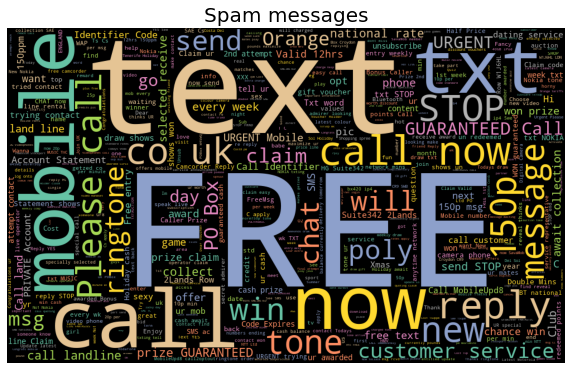

In [ ]:
show_wordcloud(data_spam, "Spam messages")

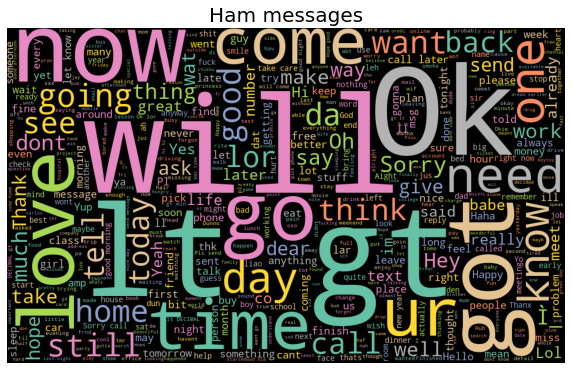

In [ ]:
show_wordcloud(data_ham, "Ham messages")

# Number of Spam Messages and Ham Messages

In [ ]:
features = data.copy()
classifiers = features.pop("classifier")

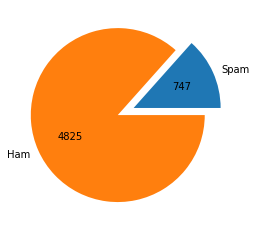

In [ ]:
classified = classifiers.to_numpy()

spam_labels = ['Spam', 'Ham']
x = np.arange(len(spam_labels))
smushed_classified = np.array([np.sum([classified==1]), np.sum([classified==0])])
spam_explode = [0.2, 0.0]
total = np.sum([classified==0]) + np.sum([classified==1])
pl.pie(smushed_classified, labels=spam_labels, explode=spam_explode, autopct=lambda p: '{:.0f}'.format(p * total / 100))
pl.show()

# Pre-Processing The Data

Reference Material: https://towardsdatascience.com/nlp-spam-detection-in-sms-text-data-using-deep-learning-b8632db85cc8

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
x_data = data['message'].values
y_data = data['classifier'].values

# Split data into train and test set
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=434)

In [ ]:
max_len = 50
trunc_type = "post" 
padding_type = "post" 
vocab_size = 500

tokenizer = Tokenizer(oov_token="<OOV>",
                      num_words=vocab_size, 
                      char_level=False)
tokenizer.fit_on_texts(x_train)

Get the word index data 

In [ ]:
word_index = tokenizer.word_index

Get the sequence of tokens for the train and test sets

In [ ]:
x_train_seq = tokenizer.texts_to_sequences(x_train)
x_test_seq = tokenizer.texts_to_sequences(x_test)

Build the lookup table

In [ ]:
id_to_word = dict((i, w) for (w,i) in word_index.items())

Encoding of ordinals

In [ ]:
word_to_id = {
    w:i for (i,w) in id_to_word.items()
}

Show the first item in the sequence list

In [ ]:
" ".join([id_to_word[i] for i in x_train_seq[0]])

'not <OOV> only <OOV> one day one <OOV> with in one month we can finish'

Let's decode some random integers because, why not?

In [ ]:
decode([14, 49, 20, 78, 106, 19, 82, 73, 90, 168])

'your how 2 txt any on stop want today meet'

Split the data into a training and test set

In [ ]:
# Sequencing and padding on training and testing 
x_train_pad = pad_sequences(x_train_seq, maxlen=max_len, padding=padding_type, truncating=trunc_type) 
x_test_pad = pad_sequences(x_test_seq, maxlen=max_len, padding=padding_type, truncating=trunc_type)

# Building our Model

We will create a simple LSTM model for detecting spam

In [ ]:
# Dense Spam Detection Model

# Parameters
embeding_dim = 32
dropout_value = 0.25 # dropout

model_lstm = models.Sequential(name="spam_filter")
model_lstm.add(layers.Embedding(vocab_size, embeding_dim, input_length=max_len, name="embedding"))
model_lstm.add(layers.LSTM(32, dropout=dropout_value, name="lstm"))
model_lstm.add(layers.Dense(32, activation='relu', name="dense_relu_1"))
model_lstm.add(layers.Dropout(dropout_value, name="dropout_1"))
model_lstm.add(layers.Dense(1, activation='sigmoid', name="output"))
model_lstm.summary()

Model: "spam_filter"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 32)            16000     
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dense_relu_1 (Dense)         (None, 32)                1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
output (Dense)               (None, 1)                 33        
Total params: 25,409
Trainable params: 25,409
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_lstm.compile(loss='binary_crossentropy',optimizer='adam' ,metrics=['acc'])

# Training Our Model

In [ ]:
# fitting a dense spam detector model
history = model_lstm.fit(x_train_pad, y_train, epochs=10, validation_data=(x_test_pad, y_test), verbose=1)

Epoch 1/10
122/122 [==============================] - 7s 31ms/step - loss: 0.5005 - acc: 0.8547 - val_loss: 0.1683 - val_acc: 0.9605
Epoch 2/10
122/122 [==============================] - 3s 28ms/step - loss: 0.1194 - acc: 0.9668 - val_loss: 0.1200 - val_acc: 0.9641
Epoch 3/10
122/122 [==============================] - 3s 27ms/step - loss: 0.0617 - acc: 0.9860 - val_loss: 0.0716 - val_acc: 0.9785
Epoch 4/10
122/122 [==============================] - 3s 27ms/step - loss: 0.0411 - acc: 0.9891 - val_loss: 0.0811 - val_acc: 0.9773
Epoch 5/10
122/122 [==============================] - 3s 27ms/step - loss: 0.0375 - acc: 0.9903 - val_loss: 0.0634 - val_acc: 0.9821
Epoch 6/10
122/122 [==============================] - 3s 27ms/step - loss: 0.0355 - acc: 0.9916 - val_loss: 0.0766 - val_acc: 0.9809
Epoch 7/10
122/122 [==============================] - 3s 26ms/step - loss: 0.0258 - acc: 0.9925 - val_loss: 0.0845 - val_acc: 0.9791
Epoch 8/10
122/122 [==============================] - 3s 26ms/step - 

# Testing Our Model

In [ ]:
# Comparing Validation loss with and without callback

In [ ]:
# Predicting
def predict_spam(predict_msg, model):
  new_seq = tokenizer.texts_to_sequences(predict_msg)
  padded = pad_sequences(new_seq, 
                          maxlen=max_len,
                          padding=padding_type,
                          truncating=trunc_type)
  predictions = model.predict(padded)
  i = 0
  for prediction in predictions:
    print("============== MESSAGE =================")
    print(predict_msg[i])
    print("----------------------------------------")
    print("LIKELY HOOD TO BE SPAM: %.2f%%"% (predictions[i][0] * 100))
    print("----------------------------------------\n")
    i = i + 1
  return predictions

In [ ]:
predict_msg = ["Call now to win free boating tickets!",
              "Call me",
              "What's up?",
              "Congrats on the free camera", 
              "Text 65783 to win a brand new Car!", 
              "yo bro did you win an iPhone?", 
              "Hey, did you just call this number?",
              "Congrats on your brand new car, text now to win", 
              "congrats on your win, text me later at 5558967345",
              "WARNING: This website contains explicit pictures, videos, stories, images, or sounds You must be 18 year henryzhes of age or older to enter. If you are under 18, or if it is forbidden to view this content in your community, you must leave this site.",
               "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's",
               "Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",
               "WINNER!! As a valued network customer you have been selected to receivea å£900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.",
               "I HAVE A DATE ON SUNDAY WITH WILL!!",
               ]
predictions_lstm = predict_spam(predict_msg, model_lstm)

============== MESSAGE =================
Call now to win free boating tickets!
----------------------------------------
LIKELY HOOD TO BE SPAM: 99.97%
----------------------------------------

============== MESSAGE =================
Call me
----------------------------------------
LIKELY HOOD TO BE SPAM: 0.05%
----------------------------------------

============== MESSAGE =================
What's up?
----------------------------------------
LIKELY HOOD TO BE SPAM: 0.04%
----------------------------------------

============== MESSAGE =================
Congrats on the free camera
----------------------------------------
LIKELY HOOD TO BE SPAM: 3.22%
----------------------------------------

============== MESSAGE =================
Text 65783 to win a brand new Car!
----------------------------------------
LIKELY HOOD TO BE SPAM: 99.92%
----------------------------------------

============== MESSAGE =================
yo bro did you win an iPhone?
-------------------------------------

# Testing With RNN

In [ ]:
model_rnn = models.Sequential(name="spam_filter_rnn")
model_rnn.add(layers.Embedding(vocab_size, embeding_dim, input_length=max_len, name="embedding"))
model_rnn.add(layers.SimpleRNN(20))
model_rnn.add(layers.Dense(64, activation='relu', name="dense_relu_1"))
model_rnn.add(layers.Dropout(dropout_value, name="dropout_1"))
model_rnn.add(layers.Dense(32, activation='relu', name="dense_relu_2"))
model_rnn.add(layers.Dropout(dropout_value, name="dropout_2"))
model_rnn.add(layers.Dense(1, activation='sigmoid', name="output"))
model_rnn.summary()

Model: "spam_filter_rnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 32)            16000     
_________________________________________________________________
simple_rnn_20 (SimpleRNN)    (None, 20)                1060      
_________________________________________________________________
dense_relu_1 (Dense)         (None, 64)                1344      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_relu_2 (Dense)         (None, 32)                2080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
output (Dense)               (None, 1)             

In [ ]:
model_rnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
history_rnn = model_rnn.fit(x_train_pad, y_train, epochs=10, validation_data=(x_test_pad, y_test), verbose=1)

Epoch 1/10
122/122 [==============================] - 3s 15ms/step - loss: 0.4796 - acc: 0.8398 - val_loss: 0.3884 - val_acc: 0.8690
Epoch 2/10
122/122 [==============================] - 2s 13ms/step - loss: 0.4139 - acc: 0.8620 - val_loss: 0.3903 - val_acc: 0.8690
Epoch 3/10
122/122 [==============================] - 1s 12ms/step - loss: 0.3921 - acc: 0.8734 - val_loss: 0.3823 - val_acc: 0.8690
Epoch 4/10
122/122 [==============================] - 2s 13ms/step - loss: 0.3567 - acc: 0.8662 - val_loss: 0.3605 - val_acc: 0.8684
Epoch 5/10
122/122 [==============================] - 1s 12ms/step - loss: 0.2807 - acc: 0.8930 - val_loss: 0.2967 - val_acc: 0.8792
Epoch 6/10
122/122 [==============================] - 2s 13ms/step - loss: 0.2428 - acc: 0.9135 - val_loss: 0.3006 - val_acc: 0.8965
Epoch 7/10
122/122 [==============================] - 2s 12ms/step - loss: 0.1896 - acc: 0.9387 - val_loss: 0.2748 - val_acc: 0.9049
Epoch 8/10
122/122 [==============================] - 1s 12ms/step - 

Predictions with the new RNN model

In [ ]:
predictions_rnn = predict_spam(predict_msg, model_rnn)

============== MESSAGE =================
Call now to win free boating tickets!
----------------------------------------
LIKELY HOOD TO BE SPAM: 2.01%
----------------------------------------

============== MESSAGE =================
Call me
----------------------------------------
LIKELY HOOD TO BE SPAM: 6.10%
----------------------------------------

============== MESSAGE =================
What's up?
----------------------------------------
LIKELY HOOD TO BE SPAM: 3.58%
----------------------------------------

============== MESSAGE =================
Congrats on the free camera
----------------------------------------
LIKELY HOOD TO BE SPAM: 2.11%
----------------------------------------

============== MESSAGE =================
Text 65783 to win a brand new Car!
----------------------------------------
LIKELY HOOD TO BE SPAM: 3.24%
----------------------------------------

============== MESSAGE =================
yo bro did you win an iPhone?
---------------------------------------

# Comparing The Predictions

In [ ]:
print("#\tLSTM\t\tRNN")
print("===============================")
for i in range(len(predictions_lstm)):
  print("%d\t%0.2f%%\t\t%0.2f%%" % (i+1, predictions_lstm[i] * 100, predictions_rnn[i] * 100))

#	LSTM		RNN
1	99.97%		2.01%
2	0.05%		6.10%
3	0.04%		3.58%
4	3.22%		2.11%
5	99.92%		3.24%
6	1.28%		2.33%
7	0.12%		3.49%
8	99.97%		97.42%
9	0.07%		13.40%
10	99.66%		10.30%
11	99.98%		98.17%
12	0.04%		2.02%
13	99.98%		90.89%
14	0.05%		2.55%
